# Align Fasta to Reference Fasta

In [44]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
import h5py  # Python Package to do the HDF5.

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

Current machine: compute-a-16-161.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


### Clean Fasta File (remove is)

In [39]:
def write_fasta(sample_line, seq_lines, savepath="", output=True):
    """Write a single Fasta file.
    sample_line: Line of the Sample to write
    seq_lines: Genotype Sequences to write
    savepath: Where to write Fasta File to
    """
    f1 = open(savepath, "w")
    f1.write(sample_line)  # Write the new line
    for line in seq_lines:
        f1.write(line)
    f1.close()
    if output:
        print(f"Saved fasta to {savepath}")
    
def fasta_iter_raw(fasta_name):
    """
    Return iterator for fasta
    """
    
    "first open the file outside "
    fh = open(fasta_name)
    # ditch the boolean (x[0]) and just keep the header or sequence since
    # we know they alternate.
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    
    for header in faiter:
        # drop the ">"
        headerStr = header.__next__()   #[1:].strip()
        # join all sequence lines to one.
        seq = "".join(s for s in faiter.__next__())  # .strip()
        yield (headerStr, seq) 
        
def fasta_iter(fasta_name):
    """
    Return iterator for fasta
    """
    "first open the file outside "
    fh = open(fasta_name)
    # ditch the boolean (x[0]) and just keep the header or sequence since
    # we know they alternate.
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))

    for header in faiter:
        # drop the ">"
        headerStr = header.__next__()[1:].strip()
        # join all sequence lines to one.
        seq = "".join(s.strip() for s in faiter.__next__())
        yield (headerStr, seq) 
        
def clean_seq_line(seq_line, replace_char=r'[^ACGTN\n\r]',
                   with_char="N"):
    """Clean seq_line String.
    Return updated string"""
    seq_line = seq_line.upper()   # Make Upper Case
    seq_line = re.sub(replace_char, with_char, seq_line)
    return seq_line

def include_samples(sample_seq, min_cov_bs):
    """Quick check whether to include sample.
    min_cov_bs: Minimum Number of covered Bases
    return include status, nr covered bases"""
    lgth = len(sample_seq) - sample_seq.count('\n') - sample_seq.count("N")
    include = True
    if lgth < min_cov_bs:
        include = False
    return include, lgth
        
def split_fasta(fasta_name, path_out="./output/singleseq/", 
                iids=[], clean=True, 
                min_cov_bs=20000, output=True):
    """
    Splits up samples from fasta if IID string contains
    clean: Whether to clean string (make everything upper-case 
    and substitute with N)
    min_cov_bs: How many bases covered at least once
    Return list of samples that have been run
    df_prev
    """
    fiter = fasta_iter_raw(fasta_name)
    
    iids_org, iids_prcsd = [], []
    cvg, icld = [], []
    
    for sample_line, seq_line in fiter:
        sample = sample_line[1:].strip()
        if sample in iids:
            if output:
                print(f"Matched: {sample}")
            sample1 = re.sub("[\|\/]", ".", sample)
            sample1 = re.sub("\s", "_", sample1) # Remplace White Spaces
            
            if clean:
                seq_line = clean_seq_line(seq_line)
            include, lgth = include_samples(seq_line, min_cov_bs=min_cov_bs)
            
            ### Append Statistics
            iids_org.append(sample)
            iids_prcsd.append(sample1)
            cvg.append(lgth)
            icld.append(include)
            
            if include:
                fasta_name_out = os.path.join(path_out, sample1 + ".fasta")
                write_fasta(sample_line, seq_line, fasta_name_out, output=output)
                
    # Make a Summary Dataframe
    df = pd.DataFrame({"iid":iids_org, "iid_clean":iids_prcsd, 
                        "cov":cvg,  "include":icld, "aligned_path": ""})
    return df
                  
def clean_fasta(fasta_name, fasta_name_out):
    """
    Remove invalid characters in sequences
    """
    "first open the file outside "
    f = open(fasta_name)
    f1 = open(fasta_name_out, "w")
    n=0
    
    for line in f:
        if line[0]==">":
            n+=1
        else:   # If Genome Data replace i
            line = line.replace("i", "N")
        f1.write(line)  # Write the new line
    f.close()
    f1.close()
    print(f"Successfully Modified {n} fastas")
    print(f"Saved to {clean_fasta_path}")
    
def align_mafft(in_path, out_path, ref_path="./data/reference/wuhan-hu-1.fasta", 
                thread=10, output=True):
    """Align in_path against ref_path using MAFFT.
    Save in out_path"""
    #command = f"mafft --out {out_path} --add {in_path} --thread {thread} --keeplength {ref_path}"
    #print(command)
    #stream = os.popen(command)
    #if output:
    #    output = stream.read()
    #    return output  
    if output:
        !mafft --out $out_path --add $in_path --thread $thread --keeplength $ref_path
    else: 
        !mafft --out $out_path --add $in_path --thread $thread --quiet --keeplength $ref_path 
    
def align_mafft_multiple(df, 
                         in_folder = "./output/singleseq/",
                         out_folder="./output/singleseq_aligned/",
                         ref_path = "./data/reference/wuhan-hu-1.fasta",
                         save_path_df = "", threads=10, output=False, overwrite=False,
                         iid_col="iid_clean", align_col = "aligned_path", icl_col="include",
                         ):
    """Align all sequences not yet aligned
    df: Dataframe with sample iids
    out_folder: Where to save 
    overwrite: Whether to overwrite existing output"""
    
    if align_col not in df:
        df[align_col] = ""

    for index, row in df.iterrows():
        iid = row[iid_col]
        align_path = row[align_col]
        align_path1 = os.path.join(out_folder, iid + ".fasta")
        icld = row[icl_col]
        
        if (align_path != align_path1) and icld: # Works also if np.nan
            if os.path.exists(align_path1) and (not overwrite):  # Check if Path already exisits
                continue
            in_path = os.path.join(in_folder, iid + ".fasta")
            
            align_mafft(in_path, out_path=align_path1, 
                        ref_path=ref_path, thread=threads, output=output)
            row[align_col] = align_path1

    if len(save_path_df)>0:
        df.to_csv(save_path_df, sep="\t", index=False)
        print(f"Saved Summary Dataframe n={len(df)} to {save_path_df}")
        
def merge_new_existing_df(path_new= "./output/single_seq_split.tsv", 
                          path_existing= "output/single_seq_aligned.tsv", 
                          savepath = "same",
                          align_col = "aligned_path"):
    """Merge New and Existing Dataframe"""
    if savepath=="same":
        savepath = path_existing

    df1 = pd.read_csv(path_new, sep="\t") 
    df2 = pd.read_csv(path_existing, sep="\t")

    ### Add the alginment to the new one:
    df1[align_col] = ""
    assert((df1.columns ==df2.columns).all())

    df_merge = pd.concat([df2,df1]) # put existing ones first
    df_merge = df_merge.drop_duplicates(subset="iid_clean", keep="first").reset_index(drop=True)

    if len(savepath)>0:
        df_merge.to_csv(savepath, sep="\t", index=False)
        print(f"Saved Summary Dataframe n={len(df_merge)} to {savepath}")
    return df_merge

### Split up the Multi FASTA into single FASTAs

In [5]:
%%time
fasta_path = "./data/apr20/gisaid_cov2020_sequences.fasta"  # Change
savepath = "./output/single_seq_split.tsv"
min_cov_bs = 20000

fiter = fasta_iter(fasta_path)
iids = np.array([ff[0] for ff in fiter])

df = split_fasta(fasta_name="./data/apr20/gisaid_cov2020_sequences.fasta", 
            path_out="./output/singleseq/", 
            iids=iids[:], clean=True, 
            min_cov_bs=min_cov_bs, output=False)

#df["include"].value_counts()
print(f"Successfully split up into single fastas.")
df.to_csv(savepath, sep="\t", index=False)
print(f"Saved Summary Dataframe n={len(df)} to {savepath}")

Successfully split up into single fastas.
Saved Summary Dataframe n=3332 to ./output/single_seq_split.tsv
CPU times: user 30.4 s, sys: 671 ms, total: 31 s
Wall time: 1min 32s


### Merge new Individuals into existing dataframe
(only keep the existing ones)

In [43]:
df_merge = merge_new_existing_df(path_new= "./output/single_seq_split.tsv", 
                          path_existing= "output/single_seq_aligned.tsv", 
                          savepath = "output/single_seq_aligned1.tsv")

Saved Summary Dataframe n=3332 to output/single_seq_aligned1.tsv


### Run the full alignment
Requires mafft in path

In [6]:
%%time
df = pd.read_csv("./output/single_seq_split.tsv", sep="\t")  

align_mafft_multiple(df, 
                     in_folder = "./output/singleseq/",
                     out_folder="./output/singleseq_aligned/",
                     ref_path = "./data/reference/wuhan-hu-1.fasta",
                     save_path_df = "output/single_seq_aligned.tsv", threads=10)

Saved Summary Dataframe n=3332 to output/single_seq_aligned.tsv
CPU times: user 12.7 s, sys: 10.4 s, total: 23.1 s
Wall time: 10min 42s


# Area 51

In [36]:
df = pd.read_csv("./output/single_seq_aligned.tsv", sep="\t") 

## Run single test alignment
(requires MAFFT in path)

In [152]:
%%time
in_path = "./output/singleseq/hCoV-19.Beijing.235.2020.EPI_ISL_413521.2020-01-28.fasta"
out_path = "./output/singleseq_aligned/test_out1.fasta"

align_mafft(in_path=in_path, out_path=out_path, thread=10, output=False)

CPU times: user 7.67 ms, sys: 11.8 ms, total: 19.5 ms
Wall time: 353 ms


In [54]:
path_fasta = in_path

fiter = fasta_iter(path_fasta)
iids = np.array([ff[0] for ff in fiter])
fiter = fasta_iter(path_fasta)
seqs = np.array([ff[1] for ff in fiter])

In [55]:
len(seqs[0])

29622

In [56]:
path_fasta = out_path

fiter = fasta_iter(path_fasta)
iids = np.array([ff[0] for ff in fiter])
fiter = fasta_iter(path_fasta)
seqs = np.array([ff[1] for ff in fiter])

In [59]:
len(seqs[1])

29903

### Load multi fasta

In [38]:
path_fasta = "./data/mar20/gisaid_cov2020_sequences_30.fasta"
fiter = fasta_iter(path_fasta)
iids = np.array([ff[0] for ff in fiter])
fiter = fasta_iter(path_fasta)  # iter_raw
seqs = np.array([ff[1] for ff in fiter])

In [63]:
target_iid = 'hCoV-19/Scotland/EDB007/2020|EPI_ISL_415634|2020-03-06'
target_iid = 'hCoV-19/USA/WA-S91/2020|EPI_ISL_417144|2020-03-02'
idx = (iids==target_iid)
#idx = (iids=="hCoV-19/Japan/DP0763/2020|EPI_ISL_416623|2020-02-17")
np.sum(idx)

1

In [64]:
seq = seqs[idx][0]
print(len(seq))

29903


In [65]:
seq[22800:23201]

'GCAAACTGGAAAGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTGAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTAATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAA'

In [24]:
np.arange(22900,23101)

array([22900, 22901, 22902, 22903, 22904, 22905, 22906, 22907, 22908,
       22909, 22910, 22911, 22912, 22913, 22914, 22915, 22916, 22917,
       22918, 22919, 22920, 22921, 22922, 22923, 22924, 22925, 22926,
       22927, 22928, 22929, 22930, 22931, 22932, 22933, 22934, 22935,
       22936, 22937, 22938, 22939, 22940, 22941, 22942, 22943, 22944,
       22945, 22946, 22947, 22948, 22949, 22950, 22951, 22952, 22953,
       22954, 22955, 22956, 22957, 22958, 22959, 22960, 22961, 22962,
       22963, 22964, 22965, 22966, 22967, 22968, 22969, 22970, 22971,
       22972, 22973, 22974, 22975, 22976, 22977, 22978, 22979, 22980,
       22981, 22982, 22983, 22984, 22985, 22986, 22987, 22988, 22989,
       22990, 22991, 22992, 22993, 22994, 22995, 22996, 22997, 22998,
       22999, 23000, 23001, 23002, 23003, 23004, 23005, 23006, 23007,
       23008, 23009, 23010, 23011, 23012, 23013, 23014, 23015, 23016,
       23017, 23018, 23019, 23020, 23021, 23022, 23023, 23024, 23025,
       23026, 23027,

### Load single fasta

In [6]:
path_fasta = "./output/singleseq/hCoV-19.Australia.NSW01.2020.EPI_ISL_407893.2020-01-24.fasta"
fiter = fasta_iter_raw(path_fasta)
iid, seq = next(fiter)

# Quick Coverage Analysis

In [14]:
fiter = fasta_iter_raw("./data/mar20/gisaid_cov2020_sequences_30.fasta")
seqs = np.array([ff[1] for ff in fiter])
covered = [len(s) - s.count('\n') - s.count("N") for s in seqs]

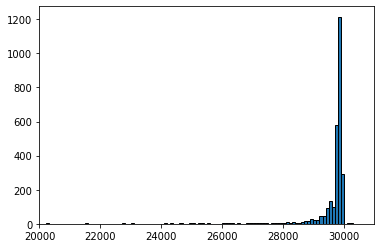

In [15]:
bins = np.arange(0, 31000, 100)
plt.figure()
ax = plt.gca()
ax.hist(covered, bins=bins, ec="k")
ax.set_xlim([20000,31000])
plt.show()

In [166]:
test = "AB   Cd E"
test1 = re.sub("\s", "_", test)
test1

'AB___Cd_E'

In [19]:
print('lol')

lol
